In [1]:
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from glob import glob

In [2]:
lp_source = 'DEU'
lp_target = 'ENU'
directory = '.'

trials = set()
data = {}
for fn in sorted(glob('./%s/*%s-%s*.npz' % (directory, lp_source, lp_target))):
    basename = fn.split('\\')[1]
    print(basename)
    
    fields = basename[:-4].split('_')
    trials.add(fields[0])
    data[(fields[0], int(fields[-1]))] = np.load(open(fn, 'rb'))

fixed_DEU-ENU_1200.npz
fixed_DEU-ENU_1800.npz
fixed_DEU-ENU_2400.npz
fixed_DEU-ENU_3000.npz
fixed_DEU-ENU_600.npz
interim-0.5pfutility_DEU-ENU_1200.npz
interim-0.5pfutility_DEU-ENU_1800.npz
interim-0.5pfutility_DEU-ENU_2119.npz
interim-0.5pfutility_DEU-ENU_2400.npz
interim-0.5pfutility_DEU-ENU_3000.npz
interim-0.5pfutility_DEU-ENU_600.npz
interim-pocock_DEU-ENU_1200.npz
interim-pocock_DEU-ENU_1800.npz
interim-pocock_DEU-ENU_2400.npz
interim-pocock_DEU-ENU_3000.npz
interim-pocock_DEU-ENU_600.npz


In [3]:
xs = list(range(200, 4201, 200))
trials = sorted(trials)

Text(0.5, 0, 'Distribution of campaign differences')

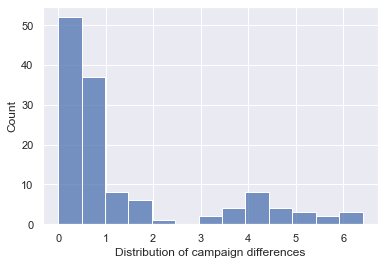

In [4]:
# histplot
one_trial = next(iter(data.keys()))
trial_data = data[one_trial]

sns.histplot(np.abs(trial_data[:,0]))
plt.xlabel('Distribution of campaign differences')

In [5]:
def get_name(trial):
    if 'futility' in trial:
        return 'interim-futility'
    elif 'interim' in trial:
        return 'interim'
    else:
        return 'fixed'

Text(0, 0.5, 'Average power (# of significant pairs)')

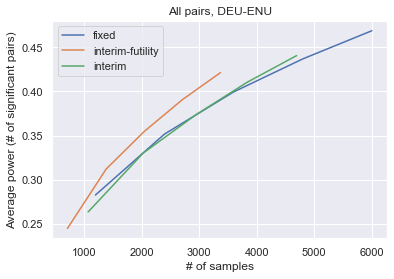

In [6]:
for trial in trials:
    name = get_name(trial)
    x, y = [], []
    for n in xs:
        try:
            trial_data = data[(trial, n)]
        except:
            continue
        x.append(trial_data.mean(axis=0)[2]*2)
        y.append(trial_data.mean(axis=0)[1])
    sns.lineplot(x=x, y=y, label=name)

plt.title('All pairs, %s-%s' % (lp_source, lp_target))
plt.xlabel('# of samples')
plt.ylabel('Average power (# of significant pairs)')

In [7]:
large_difference = 3
np.mean(np.abs(trial_data[:,0]) > large_difference)

0.19230769230769232

Text(0, 0.5, 'Average power (# of significant pairs)')

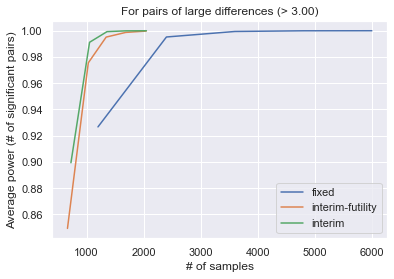

In [8]:
# large differences
for trial in trials:
    name = get_name(trial)
    x, y = [], []
    for n in xs:
        try:
            trial_data = data[(trial, n)]
        except:
            continue
            
        large_diff_mask = np.abs(trial_data[:,0]) > large_difference
        tdata = trial_data[large_diff_mask]
        
        x.append(tdata.mean(axis=0)[2]*2)
        y.append(tdata.mean(axis=0)[1])
    sns.lineplot(x=x, y=y, label=name)

plt.title('For pairs of large differences (> %.2f)' % (large_difference))
plt.xlabel('# of samples')
plt.ylabel('Average power (# of significant pairs)')

Text(0, 0.5, 'Average power (# of significant pairs)')

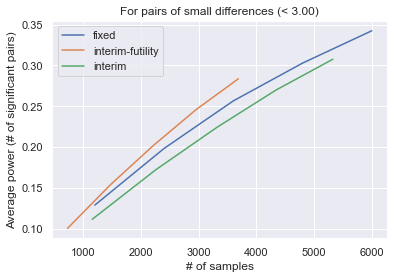

In [9]:
for trial in trials:
    name = get_name(trial)
    x, y = [], []
    for n in xs:
        try:
            trial_data = data[(trial, n)]
        except:
            continue
        
        large_diff_mask = np.abs(trial_data[:,0]) < large_difference
        tdata = trial_data[large_diff_mask]
        
        x.append(tdata.mean(axis=0)[2]*2)
        y.append(tdata.mean(axis=0)[1])
    sns.lineplot(x=x, y=y, label=name)

plt.title('For pairs of small differences (< %.2f)' % (large_difference))
plt.xlabel('# of samples')
plt.ylabel('Average power (# of significant pairs)')

Text(0, 0.5, 'Average power (of large difference pairs)')

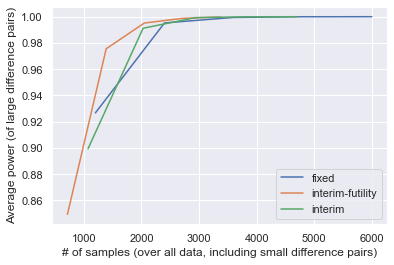

In [10]:
# large differences (taking into account all experimental cost)
for trial in trials:
    name = get_name(trial)
    x, y = [], []
    for n in xs:
        try:
            trial_data = data[(trial, n)]
        except:
            continue
            
        large_diff_mask = np.abs(trial_data[:,0]) > large_difference
        tdata = trial_data[large_diff_mask]
        
        x.append(trial_data.mean(axis=0)[2]*2)  # use all data
        y.append(tdata.mean(axis=0)[1])
    sns.lineplot(x=x, y=y, label=name)

# different kind of evaluation
# we are trying to detect meaning differences (> 1) as efficiently as possible.

# try 2 steps

# leave out pocock correction
# plt.title('For pairs of large differences (> %.2f)' % (large_difference))
plt.xlabel('# of samples (over all data, including small difference pairs)')
plt.ylabel('Average power (of large difference pairs)')

Text(0, 0.5, 'Average # of judgments collected')

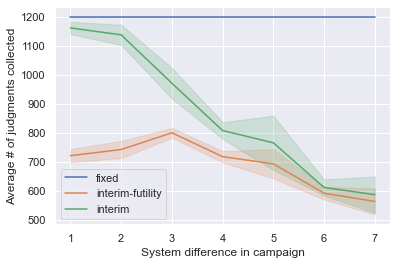

In [11]:
n = 600
for trial in trials:
    name = get_name(trial)
    trial_data = data[(trial, n)]

    diffs = np.abs(trial_data[:,0])
    bins = np.linspace(0, 10, 11)
    diff_bins = np.digitize(diffs, bins)
    sns.lineplot(x=diff_bins, y=trial_data[:,2]*2, label=name, ci='sd')
    # sns.scatterplot(x=diffs, y=trial_data[:,2]*2, label=name, ci='sd')

plt.xlabel('System difference in campaign')
plt.ylabel('Average # of judgments collected')

In [12]:
# calculate differences
pw_funcs = {}

def pwf(point, x, y):
    # assumes x and y are monotonic
    x, y = np.array(x), np.array(y)
    ind = int((point > x).sum())
    
    slope = (y[ind] - y[ind - 1]) / (x[ind] - x[ind - 1])
    val = slope * (point - x[ind - 1]) + y[ind - 1]
    
    return val

for trial in trials:
    name = get_name(trial)
    
    x, y = [], []
    for n in xs:
        try:
            trial_data = data[(trial, n)]
        except:
            continue
            
        x.append(trial_data.mean(axis=0)[2]*2)
        y.append(trial_data.mean(axis=0)[1])
    
    pw_funcs[name] = lambda point, x=x, y=y: pwf(point, x, y)

In [13]:
# calculate savings
n = 1200
power = pw_funcs['fixed'](n)

t = 0
i = n
while np.abs(t - power) > 0.0001 and i > 0:
    t = pw_funcs['interim-futility'](i)
    i -= 1
    
print(i)
print(power, pw_funcs['interim-futility'](i))
print(1 - i / n)

1092
0.2824923076923077 0.2824826515198121
0.08999999999999997


In [14]:
# calculate gains
n = 1200
power = pw_funcs['interim-futility'](n)

t = 0
i = 3000
while np.abs(t - power) > 0.0001 and i > 0:
    t = pw_funcs['fixed'](i)
    i -= 1
    
print(i)
print(power, pw_funcs['fixed'](i))
print(i / n - 1)

1388
0.293313993064039 0.2933276153846154
0.15666666666666673


In [15]:
# calculate 3x efficiency
n = 3600
power = pw_funcs['fixed'](n)

t = 0
i = 3000
while np.abs(t - power) > 0.0001 and i > 0:
    t = pw_funcs['interim-futility'](i)
    i -= 1
    
print(i)
print(power, pw_funcs['interim-futility'](i))
print(1 - i / n)

2900
0.3994846153846154 0.39950679849013904
0.19444444444444442


1200.2243076923078


<AxesSubplot:>

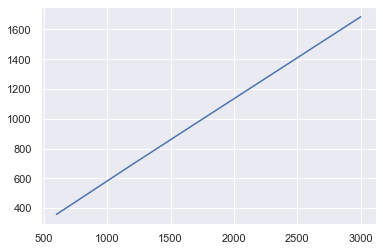

In [16]:
# calculate suitable conversion for interim sampling

x, y = [], []
for n in xs:
    try:
        trial_data = data[('interim-0.5pfutility', n)]
    except:
        continue

    x.append(n)
    y.append(trial_data[:,2].mean())

f = lambda point, x=x, y=y: pwf(point, x, y)
print(f(2119))

sns.lineplot(x=x, y=y)

1201.937846153846


Text(0.5, 1.0, 'Power comparison of interim and fixed testing when budget is 1200')

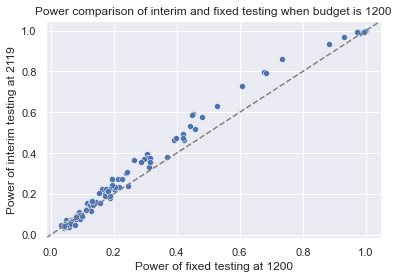

In [27]:
fixed_data = data[('fixed', 1200)]
interim_data = data[('interim-0.5pfutility', 2119)]
print(interim_data[:,2].mean())
sns.scatterplot(x=fixed_data[:,1], y=interim_data[:,1])

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='grey', scalex=False, scaley=False)

plt.xlabel('Power of fixed testing at 1200')
plt.ylabel('Power of interim testing at 2119')
plt.title('Power comparison of interim and fixed testing when budget is 1200')